In [1]:
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from matplotlib import pylab as plt

import optuna

In [2]:
token = os.environ['oanda_access_token']
account = os.environ['oanda_account_id']

In [3]:
from my_oanda.my_oanda import Bot

In [4]:
class MyBot(Bot):
    def set_param(self, a, b, c, d, stop_loss, take_profit):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.params = {"a":a, "b":b, "c":c, "d":d, "stop_loss":stop_loss, "take_profit":take_profit}
        
    def atr(self, *, period: int = 14, price: str = "C"):
        a = (self.df.H - self.df.L).abs()
        b = (self.df.H - self.df[price].shift()).abs()
        c = (self.df.L - self.df[price].shift()).abs()

        df = pd.concat([a, b, c], axis=1).max(axis=1)
        return df.ewm(span=period).mean()
        
    def strategy(self):
        rsi = self.rsi(period=self.a)
        ema = self.ema(period=self.b)
        atr = self.atr(period=self.c)
        lower = ema - atr
        upper = ema + atr
        self.buy_entry = (rsi < self.d )& (self.df.C < lower)
        self.sell_entry = (rsi > 100-self.d) & (self.df.C > upper)
        self.sell_exit = ema > self.df.C
        self.buy_exit = ema < self.df.C


In [5]:
start = "2020-1-1"
end = "2020-12-31"
glan = "M3"
inst = "USD_JPY"

In [6]:
mybot = MyBot(
    account_id=account,
    access_token=token,
    environment='live',
    instrument=inst,
    granularity=glan, # 15 second candlestick,
    folder = "../data/"
)

In [7]:
df_list = []

def objective(trial):
    a = trial.suggest_int('a', 5, 50)
    b = trial.suggest_int('b', 5, 50)
    c = trial.suggest_int('c', 5, 50)
    d = trial.suggest_int('d', 20, 40)
    
    sl = trial.suggest_int('stop_loss', 5, 50)
    tp = trial.suggest_int('take_profit', 5, 50)
    
    mybot.set_param(a, b, c, d, sl, tp)
    
    df =  mybot.backtest(from_date=start, to_date=end)
    df.loc['a'] = a
    df.loc['b'] = b
    df.loc['c'] = c
    df.loc['d'] = d
    df.loc['stop_loss'] = sl
    df.loc['take_profit'] = tp
    
    df_list.append(df)
    
    score = -df['total profit']
    #     print('a: %d, b: %d, score: %1.2f' % (a, b, -score))
    return score

In [8]:
df_list = []
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2021-02-21 11:10:00,179] A new study created in memory with name: no-name-6370a4ee-1945-4d2d-863a-b7fdc60dbdf0
[I 2021-02-21 11:10:53,399] Trial 0 finished with value: -20200.0 and parameters: {'a': 32, 'b': 10, 'c': 27, 'd': 21, 'stop_loss': 29, 'take_profit': 14}. Best is trial 0 with value: -20200.0.
[I 2021-02-21 11:10:54,337] Trial 1 finished with value: -67240.0 and parameters: {'a': 24, 'b': 24, 'c': 49, 'd': 27, 'stop_loss': 5, 'take_profit': 35}. Best is trial 1 with value: -67240.0.
[I 2021-02-21 11:10:55,340] Trial 2 finished with value: -64890.0 and parameters: {'a': 25, 'b': 41, 'c': 47, 'd': 31, 'stop_loss': 50, 'take_profit': 20}. Best is trial 1 with value: -67240.0.
[I 2021-02-21 11:10:56,206] Trial 3 finished with value: -75350.0 and parameters: {'a': 45, 'b': 18, 'c': 50, 'd': 32, 'stop_loss': 41, 'take_profit': 31}. Best is trial 3 with value: -75350.0.
[I 2021-02-21 11:10:57,185] Trial 4 finished with value: -63780.0 and parameters: {'a': 28, 'b': 20, 'c': 41, '

[I 2021-02-21 11:11:33,130] Trial 39 finished with value: -225440.0 and parameters: {'a': 8, 'b': 39, 'c': 47, 'd': 34, 'stop_loss': 5, 'take_profit': 31}. Best is trial 32 with value: -229090.0.
[I 2021-02-21 11:11:34,308] Trial 40 finished with value: -245590.0 and parameters: {'a': 7, 'b': 38, 'c': 46, 'd': 39, 'stop_loss': 5, 'take_profit': 32}. Best is trial 40 with value: -245590.0.
[I 2021-02-21 11:11:35,525] Trial 41 finished with value: -235540.0 and parameters: {'a': 8, 'b': 41, 'c': 46, 'd': 40, 'stop_loss': 5, 'take_profit': 31}. Best is trial 40 with value: -245590.0.
[I 2021-02-21 11:11:36,682] Trial 42 finished with value: -233700.0 and parameters: {'a': 8, 'b': 40, 'c': 46, 'd': 40, 'stop_loss': 5, 'take_profit': 32}. Best is trial 40 with value: -245590.0.
[I 2021-02-21 11:11:37,863] Trial 43 finished with value: -233700.0 and parameters: {'a': 8, 'b': 40, 'c': 46, 'd': 40, 'stop_loss': 5, 'take_profit': 32}. Best is trial 40 with value: -245590.0.
[I 2021-02-21 11:11:

[I 2021-02-21 11:12:17,121] Trial 79 finished with value: -51150.0 and parameters: {'a': 7, 'b': 38, 'c': 47, 'd': 30, 'stop_loss': 47, 'take_profit': 31}. Best is trial 52 with value: -255250.0.
[I 2021-02-21 11:12:18,004] Trial 80 finished with value: -68300.0 and parameters: {'a': 33, 'b': 40, 'c': 34, 'd': 28, 'stop_loss': 6, 'take_profit': 26}. Best is trial 52 with value: -255250.0.
[I 2021-02-21 11:12:19,153] Trial 81 finished with value: -229240.0 and parameters: {'a': 6, 'b': 39, 'c': 37, 'd': 30, 'stop_loss': 5, 'take_profit': 32}. Best is trial 52 with value: -255250.0.
[I 2021-02-21 11:12:20,233] Trial 82 finished with value: -238450.0 and parameters: {'a': 5, 'b': 42, 'c': 31, 'd': 31, 'stop_loss': 5, 'take_profit': 29}. Best is trial 52 with value: -255250.0.
[I 2021-02-21 11:12:21,227] Trial 83 finished with value: -201290.0 and parameters: {'a': 10, 'b': 42, 'c': 33, 'd': 27, 'stop_loss': 5, 'take_profit': 29}. Best is trial 52 with value: -255250.0.
[I 2021-02-21 11:12

[I 2021-02-21 11:13:00,365] Trial 119 finished with value: -76350.0 and parameters: {'a': 41, 'b': 45, 'c': 40, 'd': 36, 'stop_loss': 50, 'take_profit': 28}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:13:01,547] Trial 120 finished with value: -261400.0 and parameters: {'a': 6, 'b': 48, 'c': 42, 'd': 36, 'stop_loss': 5, 'take_profit': 27}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:13:02,652] Trial 121 finished with value: -245570.0 and parameters: {'a': 5, 'b': 48, 'c': 41, 'd': 36, 'stop_loss': 5, 'take_profit': 26}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:13:03,812] Trial 122 finished with value: -242530.0 and parameters: {'a': 5, 'b': 48, 'c': 42, 'd': 36, 'stop_loss': 5, 'take_profit': 26}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:13:05,098] Trial 123 finished with value: -198370.0 and parameters: {'a': 6, 'b': 48, 'c': 42, 'd': 36, 'stop_loss': 6, 'take_profit': 26}. Best is trial 113 with value: -273470.0.
[I 2021-0

[I 2021-02-21 11:13:44,144] Trial 158 finished with value: -222400.0 and parameters: {'a': 9, 'b': 48, 'c': 42, 'd': 35, 'stop_loss': 5, 'take_profit': 29}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:13:45,309] Trial 159 finished with value: -179230.0 and parameters: {'a': 7, 'b': 44, 'c': 45, 'd': 33, 'stop_loss': 6, 'take_profit': 25}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:13:46,408] Trial 160 finished with value: -180080.0 and parameters: {'a': 6, 'b': 47, 'c': 44, 'd': 34, 'stop_loss': 7, 'take_profit': 27}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:13:47,522] Trial 161 finished with value: -248600.0 and parameters: {'a': 5, 'b': 49, 'c': 41, 'd': 35, 'stop_loss': 5, 'take_profit': 31}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:13:48,705] Trial 162 finished with value: -255270.0 and parameters: {'a': 6, 'b': 50, 'c': 42, 'd': 35, 'stop_loss': 5, 'take_profit': 29}. Best is trial 113 with value: -273470.0.
[I 2021-02

[I 2021-02-21 11:14:27,403] Trial 197 finished with value: -192260.0 and parameters: {'a': 9, 'b': 24, 'c': 48, 'd': 35, 'stop_loss': 6, 'take_profit': 29}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:14:28,500] Trial 198 finished with value: -245080.0 and parameters: {'a': 8, 'b': 21, 'c': 41, 'd': 34, 'stop_loss': 5, 'take_profit': 31}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:14:29,676] Trial 199 finished with value: -173930.0 and parameters: {'a': 6, 'b': 26, 'c': 40, 'd': 33, 'stop_loss': 7, 'take_profit': 34}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:14:30,818] Trial 200 finished with value: -249340.0 and parameters: {'a': 5, 'b': 25, 'c': 41, 'd': 35, 'stop_loss': 5, 'take_profit': 27}. Best is trial 113 with value: -273470.0.
[I 2021-02-21 11:14:31,946] Trial 201 finished with value: -208020.0 and parameters: {'a': 7, 'b': 50, 'c': 42, 'd': 34, 'stop_loss': 6, 'take_profit': 28}. Best is trial 113 with value: -273470.0.
[I 2021-02

[I 2021-02-21 11:15:11,680] Trial 236 finished with value: -183670.0 and parameters: {'a': 6, 'b': 42, 'c': 47, 'd': 38, 'stop_loss': 6, 'take_profit': 27}. Best is trial 227 with value: -273640.0.
[I 2021-02-21 11:15:12,773] Trial 237 finished with value: -266670.0 and parameters: {'a': 6, 'b': 45, 'c': 47, 'd': 37, 'stop_loss': 5, 'take_profit': 26}. Best is trial 227 with value: -273640.0.
[I 2021-02-21 11:15:14,129] Trial 238 finished with value: -258030.0 and parameters: {'a': 6, 'b': 45, 'c': 48, 'd': 37, 'stop_loss': 5, 'take_profit': 24}. Best is trial 227 with value: -273640.0.
[I 2021-02-21 11:15:15,245] Trial 239 finished with value: -188470.0 and parameters: {'a': 6, 'b': 44, 'c': 48, 'd': 38, 'stop_loss': 6, 'take_profit': 25}. Best is trial 227 with value: -273640.0.
[I 2021-02-21 11:15:16,457] Trial 240 finished with value: -246030.0 and parameters: {'a': 5, 'b': 43, 'c': 47, 'd': 36, 'stop_loss': 5, 'take_profit': 26}. Best is trial 227 with value: -273640.0.
[I 2021-02

[I 2021-02-21 11:15:56,189] Trial 275 finished with value: -257240.0 and parameters: {'a': 5, 'b': 32, 'c': 40, 'd': 36, 'stop_loss': 5, 'take_profit': 32}. Best is trial 247 with value: -276020.0.
[I 2021-02-21 11:15:57,313] Trial 276 finished with value: -207220.0 and parameters: {'a': 7, 'b': 46, 'c': 46, 'd': 39, 'stop_loss': 6, 'take_profit': 30}. Best is trial 247 with value: -276020.0.
[I 2021-02-21 11:15:58,447] Trial 277 finished with value: -166530.0 and parameters: {'a': 6, 'b': 41, 'c': 50, 'd': 37, 'stop_loss': 8, 'take_profit': 35}. Best is trial 247 with value: -276020.0.
[I 2021-02-21 11:15:59,568] Trial 278 finished with value: -226950.0 and parameters: {'a': 8, 'b': 41, 'c': 47, 'd': 35, 'stop_loss': 5, 'take_profit': 29}. Best is trial 247 with value: -276020.0.
[I 2021-02-21 11:16:00,681] Trial 279 finished with value: -204590.0 and parameters: {'a': 5, 'b': 45, 'c': 41, 'd': 36, 'stop_loss': 7, 'take_profit': 32}. Best is trial 247 with value: -276020.0.
[I 2021-02

[I 2021-02-21 11:16:40,336] Trial 314 finished with value: -262770.0 and parameters: {'a': 6, 'b': 17, 'c': 45, 'd': 37, 'stop_loss': 5, 'take_profit': 33}. Best is trial 306 with value: -281350.0.
[I 2021-02-21 11:16:41,247] Trial 315 finished with value: -84320.0 and parameters: {'a': 45, 'b': 43, 'c': 47, 'd': 36, 'stop_loss': 7, 'take_profit': 35}. Best is trial 306 with value: -281350.0.
[I 2021-02-21 11:16:42,450] Trial 316 finished with value: -273970.0 and parameters: {'a': 6, 'b': 29, 'c': 47, 'd': 37, 'stop_loss': 5, 'take_profit': 33}. Best is trial 306 with value: -281350.0.
[I 2021-02-21 11:16:43,562] Trial 317 finished with value: -272900.0 and parameters: {'a': 6, 'b': 8, 'c': 44, 'd': 35, 'stop_loss': 5, 'take_profit': 33}. Best is trial 306 with value: -281350.0.
[I 2021-02-21 11:16:44,766] Trial 318 finished with value: -203690.0 and parameters: {'a': 6, 'b': 30, 'c': 44, 'd': 35, 'stop_loss': 6, 'take_profit': 33}. Best is trial 306 with value: -281350.0.
[I 2021-02-

[I 2021-02-21 11:17:23,453] Trial 353 finished with value: -245790.0 and parameters: {'a': 5, 'b': 15, 'c': 50, 'd': 36, 'stop_loss': 6, 'take_profit': 36}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:17:24,282] Trial 354 finished with value: -32980.0 and parameters: {'a': 40, 'b': 13, 'c': 50, 'd': 25, 'stop_loss': 5, 'take_profit': 36}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:17:25,354] Trial 355 finished with value: -209970.0 and parameters: {'a': 6, 'b': 16, 'c': 49, 'd': 36, 'stop_loss': 7, 'take_profit': 37}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:17:26,495] Trial 356 finished with value: -242310.0 and parameters: {'a': 6, 'b': 12, 'c': 50, 'd': 36, 'stop_loss': 6, 'take_profit': 35}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:17:27,624] Trial 357 finished with value: -218220.0 and parameters: {'a': 5, 'b': 13, 'c': 49, 'd': 36, 'stop_loss': 9, 'take_profit': 38}. Best is trial 350 with value: -306440.0.
[I 2021-02

[I 2021-02-21 11:18:07,790] Trial 392 finished with value: -290870.0 and parameters: {'a': 7, 'b': 15, 'c': 47, 'd': 37, 'stop_loss': 5, 'take_profit': 33}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:18:08,775] Trial 393 finished with value: -203200.0 and parameters: {'a': 27, 'b': 15, 'c': 47, 'd': 37, 'stop_loss': 5, 'take_profit': 33}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:18:09,825] Trial 394 finished with value: -113460.0 and parameters: {'a': 7, 'b': 14, 'c': 48, 'd': 37, 'stop_loss': 23, 'take_profit': 34}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:18:10,995] Trial 395 finished with value: -223710.0 and parameters: {'a': 8, 'b': 17, 'c': 47, 'd': 36, 'stop_loss': 7, 'take_profit': 35}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:18:12,108] Trial 396 finished with value: -282670.0 and parameters: {'a': 6, 'b': 16, 'c': 49, 'd': 37, 'stop_loss': 5, 'take_profit': 33}. Best is trial 350 with value: -306440.0.
[I 2021-

[I 2021-02-21 11:18:52,002] Trial 431 finished with value: -259230.0 and parameters: {'a': 5, 'b': 16, 'c': 50, 'd': 38, 'stop_loss': 5, 'take_profit': 43}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:18:53,092] Trial 432 finished with value: -251060.0 and parameters: {'a': 5, 'b': 15, 'c': 49, 'd': 38, 'stop_loss': 6, 'take_profit': 46}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:18:53,991] Trial 433 finished with value: -119400.0 and parameters: {'a': 34, 'b': 14, 'c': 50, 'd': 38, 'stop_loss': 8, 'take_profit': 41}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:18:55,141] Trial 434 finished with value: -151840.0 and parameters: {'a': 7, 'b': 17, 'c': 49, 'd': 39, 'stop_loss': 13, 'take_profit': 44}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:18:56,312] Trial 435 finished with value: -293100.0 and parameters: {'a': 6, 'b': 15, 'c': 49, 'd': 39, 'stop_loss': 5, 'take_profit': 45}. Best is trial 350 with value: -306440.0.
[I 2021-

[I 2021-02-21 11:19:35,983] Trial 470 finished with value: -271130.0 and parameters: {'a': 5, 'b': 12, 'c': 48, 'd': 38, 'stop_loss': 5, 'take_profit': 38}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:19:37,071] Trial 471 finished with value: -263510.0 and parameters: {'a': 5, 'b': 11, 'c': 47, 'd': 37, 'stop_loss': 6, 'take_profit': 38}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:19:38,237] Trial 472 finished with value: -244280.0 and parameters: {'a': 5, 'b': 12, 'c': 48, 'd': 26, 'stop_loss': 5, 'take_profit': 38}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:19:39,432] Trial 473 finished with value: -208310.0 and parameters: {'a': 6, 'b': 14, 'c': 46, 'd': 37, 'stop_loss': 7, 'take_profit': 39}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:19:40,492] Trial 474 finished with value: -85390.0 and parameters: {'a': 5, 'b': 17, 'c': 49, 'd': 37, 'stop_loss': 44, 'take_profit': 40}. Best is trial 350 with value: -306440.0.
[I 2021-02

[I 2021-02-21 11:20:19,814] Trial 509 finished with value: -151340.0 and parameters: {'a': 21, 'b': 12, 'c': 49, 'd': 37, 'stop_loss': 10, 'take_profit': 37}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:20:20,884] Trial 510 finished with value: -283830.0 and parameters: {'a': 7, 'b': 10, 'c': 46, 'd': 36, 'stop_loss': 5, 'take_profit': 42}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:20:21,991] Trial 511 finished with value: -233850.0 and parameters: {'a': 7, 'b': 10, 'c': 44, 'd': 36, 'stop_loss': 7, 'take_profit': 41}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:20:22,995] Trial 512 finished with value: -115290.0 and parameters: {'a': 9, 'b': 11, 'c': 45, 'd': 36, 'stop_loss': 20, 'take_profit': 44}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:20:24,082] Trial 513 finished with value: -260800.0 and parameters: {'a': 8, 'b': 10, 'c': 46, 'd': 36, 'stop_loss': 5, 'take_profit': 38}. Best is trial 350 with value: -306440.0.
[I 2021

[I 2021-02-21 11:21:03,221] Trial 548 finished with value: -200000.0 and parameters: {'a': 6, 'b': 11, 'c': 25, 'd': 37, 'stop_loss': 8, 'take_profit': 48}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:21:04,087] Trial 549 finished with value: -124930.0 and parameters: {'a': 42, 'b': 13, 'c': 49, 'd': 36, 'stop_loss': 5, 'take_profit': 48}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:21:05,174] Trial 550 finished with value: -167940.0 and parameters: {'a': 13, 'b': 12, 'c': 14, 'd': 37, 'stop_loss': 6, 'take_profit': 50}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:21:06,275] Trial 551 finished with value: -282420.0 and parameters: {'a': 7, 'b': 10, 'c': 48, 'd': 36, 'stop_loss': 5, 'take_profit': 46}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:21:07,371] Trial 552 finished with value: -222020.0 and parameters: {'a': 6, 'b': 14, 'c': 50, 'd': 37, 'stop_loss': 6, 'take_profit': 47}. Best is trial 350 with value: -306440.0.
[I 2021-

[I 2021-02-21 11:21:47,032] Trial 587 finished with value: -246350.0 and parameters: {'a': 6, 'b': 10, 'c': 44, 'd': 37, 'stop_loss': 6, 'take_profit': 38}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:21:48,124] Trial 588 finished with value: -270720.0 and parameters: {'a': 7, 'b': 8, 'c': 46, 'd': 35, 'stop_loss': 5, 'take_profit': 39}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:21:49,172] Trial 589 finished with value: -213960.0 and parameters: {'a': 10, 'b': 13, 'c': 47, 'd': 37, 'stop_loss': 7, 'take_profit': 41}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:21:50,283] Trial 590 finished with value: -244180.0 and parameters: {'a': 5, 'b': 12, 'c': 48, 'd': 38, 'stop_loss': 6, 'take_profit': 43}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:21:51,421] Trial 591 finished with value: -270040.0 and parameters: {'a': 8, 'b': 11, 'c': 45, 'd': 37, 'stop_loss': 5, 'take_profit': 44}. Best is trial 350 with value: -306440.0.
[I 2021-02

[I 2021-02-21 11:22:30,633] Trial 626 finished with value: -240390.0 and parameters: {'a': 6, 'b': 9, 'c': 45, 'd': 40, 'stop_loss': 6, 'take_profit': 45}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:22:31,704] Trial 627 finished with value: -210310.0 and parameters: {'a': 9, 'b': 11, 'c': 44, 'd': 39, 'stop_loss': 7, 'take_profit': 47}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:22:32,820] Trial 628 finished with value: -270320.0 and parameters: {'a': 6, 'b': 8, 'c': 45, 'd': 40, 'stop_loss': 5, 'take_profit': 43}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:22:33,964] Trial 629 finished with value: -205660.0 and parameters: {'a': 7, 'b': 12, 'c': 43, 'd': 39, 'stop_loss': 8, 'take_profit': 37}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:22:35,042] Trial 630 finished with value: -293880.0 and parameters: {'a': 6, 'b': 11, 'c': 45, 'd': 38, 'stop_loss': 5, 'take_profit': 39}. Best is trial 350 with value: -306440.0.
[I 2021-02-2

[I 2021-02-21 11:23:14,805] Trial 665 finished with value: -250560.0 and parameters: {'a': 7, 'b': 9, 'c': 45, 'd': 36, 'stop_loss': 6, 'take_profit': 37}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:23:15,880] Trial 666 finished with value: -281700.0 and parameters: {'a': 6, 'b': 11, 'c': 46, 'd': 28, 'stop_loss': 5, 'take_profit': 38}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:23:17,122] Trial 667 finished with value: -234750.0 and parameters: {'a': 7, 'b': 10, 'c': 47, 'd': 36, 'stop_loss': 7, 'take_profit': 36}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:23:18,268] Trial 668 finished with value: -245480.0 and parameters: {'a': 6, 'b': 12, 'c': 45, 'd': 31, 'stop_loss': 6, 'take_profit': 38}. Best is trial 350 with value: -306440.0.
[I 2021-02-21 11:23:19,216] Trial 669 finished with value: -106960.0 and parameters: {'a': 25, 'b': 13, 'c': 46, 'd': 35, 'stop_loss': 17, 'take_profit': 37}. Best is trial 350 with value: -306440.0.
[I 2021-0

[I 2021-02-21 11:23:58,254] Trial 704 finished with value: -272930.0 and parameters: {'a': 5, 'b': 12, 'c': 48, 'd': 38, 'stop_loss': 5, 'take_profit': 39}. Best is trial 685 with value: -308430.0.
[I 2021-02-21 11:23:59,356] Trial 705 finished with value: -256010.0 and parameters: {'a': 7, 'b': 11, 'c': 47, 'd': 35, 'stop_loss': 6, 'take_profit': 35}. Best is trial 685 with value: -308430.0.
[I 2021-02-21 11:24:00,479] Trial 706 finished with value: -235820.0 and parameters: {'a': 5, 'b': 9, 'c': 45, 'd': 36, 'stop_loss': 7, 'take_profit': 40}. Best is trial 685 with value: -308430.0.
[I 2021-02-21 11:24:01,615] Trial 707 finished with value: -300400.0 and parameters: {'a': 6, 'b': 15, 'c': 49, 'd': 37, 'stop_loss': 5, 'take_profit': 38}. Best is trial 685 with value: -308430.0.
[I 2021-02-21 11:24:02,790] Trial 708 finished with value: -231170.0 and parameters: {'a': 5, 'b': 16, 'c': 49, 'd': 37, 'stop_loss': 6, 'take_profit': 38}. Best is trial 685 with value: -308430.0.
[I 2021-02-

[I 2021-02-21 11:24:41,180] Trial 743 finished with value: -133570.0 and parameters: {'a': 19, 'b': 16, 'c': 46, 'd': 29, 'stop_loss': 6, 'take_profit': 37}. Best is trial 685 with value: -308430.0.
[I 2021-02-21 11:24:42,339] Trial 744 finished with value: -282290.0 and parameters: {'a': 7, 'b': 12, 'c': 49, 'd': 34, 'stop_loss': 5, 'take_profit': 38}. Best is trial 685 with value: -308430.0.
[I 2021-02-21 11:24:43,495] Trial 745 finished with value: -293970.0 and parameters: {'a': 5, 'b': 11, 'c': 48, 'd': 36, 'stop_loss': 5, 'take_profit': 40}. Best is trial 685 with value: -308430.0.
[I 2021-02-21 11:24:44,673] Trial 746 finished with value: -221950.0 and parameters: {'a': 5, 'b': 13, 'c': 17, 'd': 38, 'stop_loss': 7, 'take_profit': 41}. Best is trial 685 with value: -308430.0.
[I 2021-02-21 11:24:45,921] Trial 747 finished with value: -261420.0 and parameters: {'a': 5, 'b': 14, 'c': 50, 'd': 32, 'stop_loss': 5, 'take_profit': 40}. Best is trial 685 with value: -308430.0.
[I 2021-0

[I 2021-02-21 11:25:27,008] Trial 782 finished with value: -247980.0 and parameters: {'a': 6, 'b': 9, 'c': 49, 'd': 36, 'stop_loss': 6, 'take_profit': 40}. Best is trial 763 with value: -310090.0.


KeyboardInterrupt: 

In [9]:
df_all = pd.concat(df_list, axis=1).T
df_over_spread = df_all[df_all['average return'] > 40].sort_values('total profit', ascending=False)
df_over_spread

,total profit,total trades,win rate,profit factor,maximum drawdown,recovery factor,riskreward ratio,sharpe ratio,average return,stop loss,take profit,a,b,c,d,stop_loss,take_profit
21,134370.0,2648.0,66.088,1.209,18400.0,7.303,0.617,0.064,47.134,356.0,5.0,16.0,9.0,35.0,26.0,14.0,50.0
11,105480.0,2084.0,63.724,1.219,18910.0,5.578,0.724,0.070,45.834,474.0,4.0,17.0,7.0,37.0,25.0,9.0,49.0
10,103160.0,2163.0,65.788,1.208,20720.0,4.979,0.625,0.063,43.985,267.0,4.0,17.0,7.0,36.0,26.0,14.0,49.0
98,83770.0,1191.0,55.416,1.150,25700.0,3.260,0.979,0.056,64.491,498.0,31.0,50.0,45.0,44.0,35.0,11.0,39.0
119,76350.0,1345.0,69.071,1.128,27880.0,2.739,0.506,0.038,53.107,62.0,53.0,41.0,45.0,40.0,36.0,50.0,28.0
3,75350.0,661.0,66.566,1.341,15720.0,4.793,0.673,0.093,107.067,26.0,21.0,45.0,18.0,50.0,32.0,41.0,31.0
80,68300.0,1028.0,44.942,1.179,28710.0,2.379,1.629,0.068,57.759,634.0,51.0,33.0,40.0,34.0,28.0,6.0,26.0
12,59490.0,1236.0,63.026,1.221,13290.0,4.476,0.839,0.074,42.450,427.0,3.0,17.0,5.0,38.0,22.0,6.0,46.0
36,44430.0,582.0,63.918,1.260,12430.0,3.574,0.755,0.084,69.844,141.0,11.0,47.0,8.0,50.0,31.0,11.0,34.0
354,32980.0,285.0,52.632,1.406,6790.0,4.857,1.546,0.128,98.567,162.0,5.0,40.0,13.0,50.0,25.0,5.0,36.0


In [10]:
params = dict(df_over_spread[["a","b","c","d","stop_loss", "take_profit"]].iloc[0].astype(int))

In [11]:
# params=study.best_trial.params

In [12]:
params

{'a': 16, 'b': 9, 'c': 35, 'd': 26, 'stop_loss': 14, 'take_profit': 50}

In [13]:
mybot.set_param(params['a'], params['b'], params['c'], params['d'], params['stop_loss'], params['take_profit'])

total profit        134370.000
total trades          2648.000
win rate                66.088
profit factor            1.209
maximum drawdown     18400.000
recovery factor          7.303
riskreward ratio         0.617
sharpe ratio             0.064
average return          47.134
stop loss              356.000
take profit              5.000
dtype: float64


total profit        134370.000
total trades          2648.000
win rate                66.088
profit factor            1.209
maximum drawdown     18400.000
recovery factor          7.303
riskreward ratio         0.617
sharpe ratio             0.064
average return          47.134
stop loss              356.000
take profit              5.000
dtype: float64

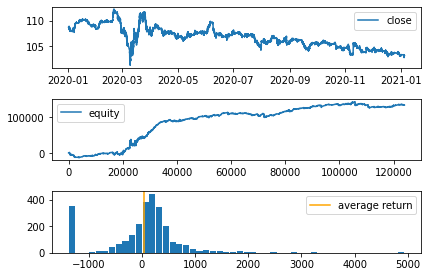

In [14]:
mybot.backtest(from_date=start, to_date=end, filename="hogebacktest.png", show=True)

total profit        19230.000
total trades          331.000
win rate               71.299
profit factor           1.456
maximum drawdown     3890.000
recovery factor         4.943
riskreward ratio        0.549
sharpe ratio            0.133
average return         55.666
stop loss              16.000
take profit             0.000
dtype: float64


total profit        19230.000
total trades          331.000
win rate               71.299
profit factor           1.456
maximum drawdown     3890.000
recovery factor         4.943
riskreward ratio        0.549
sharpe ratio            0.133
average return         55.666
stop loss              16.000
take profit             0.000
dtype: float64

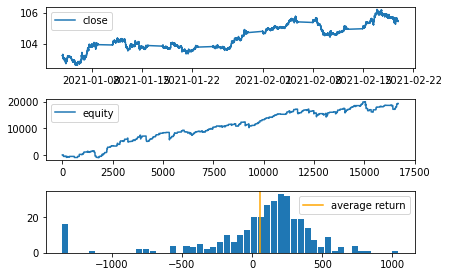

In [15]:
start_rev = "2021-1-1"
end_rev = "2021-2-19"
mybot.backtest(from_date=start_rev, to_date=end_rev, filename="hogebacktest.png", show=True)

In [ ]:
#total profit        14490.000